In [2]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def process_audio_files_in_batches(audio_dir, save_dir, img_size=(64, 64), batch_size=20, max_files_per_class=500):
    """
    Process .wav files in batches, convert them to mel spectrogram images, and save them in class-specific folders.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    file_count = {}
    batch = []
    
    for root, dirs, files in os.walk(audio_dir):
        class_name = os.path.basename(root)
        if class_name not in file_count:
            file_count[class_name] = 0
        
        for file in files:
            if file.endswith('.wav') and file_count[class_name] < max_files_per_class:
                file_path = os.path.join(root, file)
                batch.append((file_path, class_name))
                file_count[class_name] += 1

                if len(batch) == batch_size:
                    process_batch(batch, save_dir, img_size)
                    batch = []  # Clear batch after processing

        # If batch size is not reached but class limit is reached, process the batch
        if batch and file_count[class_name] >= max_files_per_class:
            process_batch(batch, save_dir, img_size)
            batch = []

    # Process any remaining files
    if batch:
        process_batch(batch, save_dir, img_size)

def process_batch(batch, save_dir, img_size):
    """
    Convert a batch of audio files to mel spectrogram images and save them.
    """
    for file_path, class_name in batch:
        class_save_dir = os.path.join(save_dir, class_name)

        if not os.path.exists(class_save_dir):
            os.makedirs(class_save_dir)

        # Load audio file and handle short audio files
        y, sr = librosa.load(file_path, sr=16000)
        n_fft = min(2048, len(y))  # Adjust n_fft based on the length of the audio signal

        # Dynamically adjust fmax to be lower than half of the sampling rate (Nyquist frequency)
        fmax = min(8000, sr / 2)

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=img_size[0], fmax=fmax, n_fft=n_fft)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Plot and save the mel spectrogram
        plt.figure(figsize=(img_size[0]/100, img_size[1]/100))
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
        plt.axis('off')

        save_path = os.path.join(class_save_dir, os.path.basename(file_path).replace('.wav', '.png'))
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()

# Parameters
audio_dir = '/Users/adityachavan/Desktop/SIH_2024/speech_commands_v0.02'
save_dir = '/Users/adityachavan/Desktop/SIH_2024/New_dataset'
batch_size = 20
process_audio_files_in_batches(audio_dir, save_dir, img_size=(64, 64), batch_size=batch_size, max_files_per_class=500)


In [3]:
image_size = 64

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import librosa
import librosa.display
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
import itertools

# Function to load dataset and print class distribution
def load_and_preprocess_data(data_dir, batch_size, img_size=(128, 128)):
    train_dataset = image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=img_size,
        label_mode='int',
        seed=123,
        validation_split=0.2,
        subset="training",
        shuffle=True
    )
    
    test_dataset = image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=img_size,
        label_mode='int',
        seed=123,
        validation_split=0.2,
        subset="validation",
        shuffle=True
    )
    
    # Print class distribution
    class_names = train_dataset.class_names
    print(f"Number of Classes: {len(class_names)}")
    class_counts = np.zeros(len(class_names))

    for _, labels in train_dataset:
        class_counts += np.bincount(labels.numpy(), minlength=len(class_names))

    print(f"Samples per Class: {dict(zip(class_names, class_counts))}")
    print(f"Total Samples: {int(np.sum(class_counts))}")

    return train_dataset, test_dataset, class_names


# Load dataset
data_dir = "/Users/adityachavan/Desktop/SIH_2024/New_dataset"
batch_size = 32
img_size = (image_size, image_size)

train_dataset, val_dataset, class_names = load_and_preprocess_data(data_dir, batch_size, img_size)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.


2024-09-29 19:27:54.390384: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-29 19:27:54.390431: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-29 19:27:54.390444: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-29 19:27:54.390745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-29 19:27:54.390802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 5000 files belonging to 10 classes.
Using 1000 files for validation.
Number of Classes: 10
Samples per Class: {'cat': 411.0, 'go': 410.0, 'happy': 418.0, 'nine': 385.0, 'one': 398.0, 'six': 401.0, 'three': 395.0, 'up': 397.0, 'wow': 397.0, 'yes': 388.0}
Total Samples: 4000


2024-09-29 19:27:55.109136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


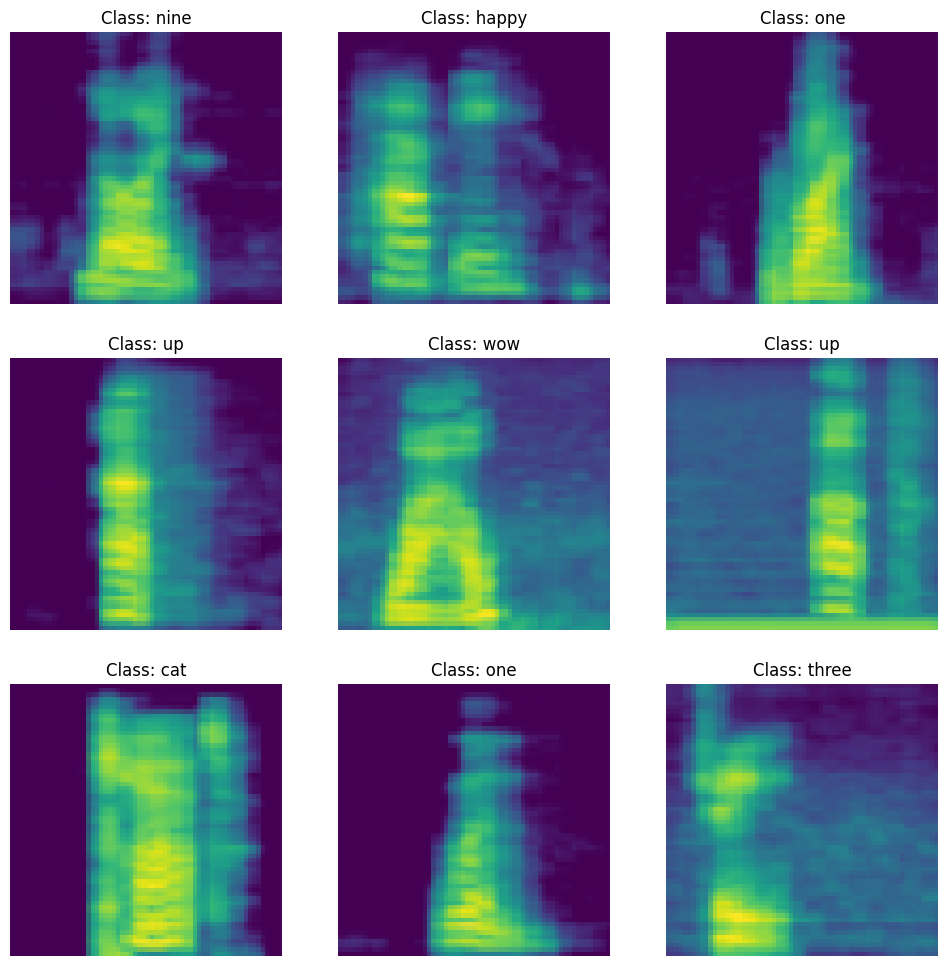

2024-09-29 19:27:58.723993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Function to visualize the first batch of images
def visualize_first_batch(dataset, class_names):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(12, 12))
        for i in range(min(9, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Class: {class_names[labels[i]]}")
            plt.axis("off")
        plt.show()

# Visualize the first batch
visualize_first_batch(train_dataset, class_names)

In [8]:
# # Create CNN backbone for Siamese network
# def create_siamese_cnn(input_shape):
#     model = Sequential([
#         layers.Rescaling(1./255),
#         layers.Reshape(input_shape),
#         layers.Conv2D(32, (3,3), activation='relu'),
#         layers.MaxPooling2D(2,2),
#         layers.BatchNormalization(),

#         layers.Conv2D(64, (3,3), activation='relu'),
#         layers.MaxPooling2D(2,2),
#         layers.BatchNormalization(),
        
#         layers.Conv2D(128, (3,3), activation='relu'),
#         layers.MaxPooling2D(2,2),
#         layers.BatchNormalization(),
        
#         layers.Conv2D(256, (3,3), activation='relu'),
#         layers.MaxPooling2D(2,2),
#         layers.BatchNormalization(),
        
#         layers.Conv2D(512, (3,3), activation='relu'),
#         layers.MaxPooling2D(2,2),
#         layers.BatchNormalization(),
        
#         layers.Flatten(),
#         layers.Dense(512, activation='relu'),
#         layers.Dropout(0.2),

#         layers.Dense(256, activation='relu'),
#         layers.Dropout(0.2),
        
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.2),
        
#         layers.Dense(64, activation='relu')
#     ])
#     # model.summary()
#     return model

# # Input for two images
# img_A_inp = layers.Input((128, 128, 3), name='img_A_inp')
# img_B_inp = layers.Input((128, 128, 3), name='img_B_inp')

# # Create the CNN model for both inputs
# model = create_siamese_cnn((128, 128, 3))
# feature_vector_A = model(img_A_inp)
# feature_vector_B = model(img_B_inp)

# # Concatenate feature vectors and add final layers
# concat = layers.Concatenate()([feature_vector_A, feature_vector_B])
# dense = layers.Dense(32, activation='relu')(concat)
# output = layers.Dense(1, activation='sigmoid')(dense)

# # Compile the Siamese network model
# siamese_model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)
# siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# siamese_model.summary()

from tensorflow.keras.applications import EfficientNetB0

def create_siamese_efficientnet(input_shape):
    # Load the pre-trained EfficientNet model
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom top layers
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        # layers.Dense(512, activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu')
    ])
    
    return model

# Input for two images
img_A_inp = layers.Input((image_size, image_size, 3), name='img_A_inp')
img_B_inp = layers.Input((image_size, image_size, 3), name='img_B_inp')

# Create the EfficientNet model for both inputs
model = create_siamese_efficientnet((image_size, image_size, 3))
feature_vector_A = model(img_A_inp)
feature_vector_B = model(img_B_inp)

# Concatenate feature vectors and add final layers
concat = layers.Concatenate()([feature_vector_A, feature_vector_B])
dense = layers.Dense(32, activation='relu')(concat)
output = layers.Dense(1, activation='sigmoid')(dense)

# Compile the Siamese network model
siamese_model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_A_inp           │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_B_inp           │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │  4,418,659 │ img_A_inp[0][0],  │
│ (Sequential)        │                   │            │ img_B_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,422,820 (16.87 MB)

 Trainable params: 373,249 (1.42 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# Function to create pairs of images for the Siamese network
def make_paired_dataset(X, y):
    X_pairs, y_pairs = [], []

    tuples = [(x1, y1) for x1, y1 in zip(X, y)]

    for t in itertools.product(tuples, tuples):
        pair_A, pair_B = t
        img_A, label_A = t[0]
        img_B, label_B = t[1]

        new_label = int(label_A == label_B)

        X_pairs.append([img_A, img_B])
        y_pairs.append(new_label)

    X_pairs = np.array(X_pairs)
    y_pairs = np.array(y_pairs)

    return X_pairs, y_pairs

In [10]:
import numpy as np
import collections
from sklearn.utils import resample

# Randomly sample 300 examples from the training data
X_train = np.array([img.numpy() for img, _ in train_dataset.unbatch()])
y_train = np.array([label.numpy() for _, label in train_dataset.unbatch()])

random_indices = np.random.choice(X_train.shape[0], 300, replace=False)
X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

# Check class distribution in the sampled data
class_distribution = collections.Counter(y_train_sample)
print("Class distribution in sampled data:", class_distribution)

# Function to balance the dataset
def balance_dataset(X, y):
    unique_classes = np.unique(y)
    min_samples = min(collections.Counter(y).values())
    
    balanced_X, balanced_y = [], []
    for cls in unique_classes:
        X_class = X[y == cls]
        y_class = y[y == cls]
        
        X_class_balanced, y_class_balanced = resample(X_class, y_class, 
                                                      replace=False, 
                                                      n_samples=min_samples, 
                                                      random_state=42)
        
        balanced_X.append(X_class_balanced)
        balanced_y.append(y_class_balanced)
    
    balanced_X = np.concatenate(balanced_X)
    balanced_y = np.concatenate(balanced_y)
    
    return balanced_X, balanced_y

# Balance the sampled data
X_train_sample_balanced, y_train_sample_balanced = balance_dataset(X_train_sample, y_train_sample)

# Check the class distribution in the balanced data
balanced_class_distribution = collections.Counter(y_train_sample_balanced)
print("Class distribution in balanced sampled data:", balanced_class_distribution)

# Create pairs of training data
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample_balanced, y_train_sample_balanced)

print(X_train_pairs.shape, y_train_pairs.shape)

2024-09-29 19:28:29.984226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-29 19:28:30.328527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class distribution in sampled data: Counter({0: 43, 1: 37, 5: 34, 2: 31, 9: 27, 8: 27, 6: 26, 7: 26, 4: 25, 3: 24})
Class distribution in balanced sampled data: Counter({0: 24, 1: 24, 2: 24, 3: 24, 4: 24, 5: 24, 6: 24, 7: 24, 8: 24, 9: 24})
(57600, 2, 64, 64, 3) (57600,)


In [12]:
import numpy as np
import collections
from sklearn.utils import resample

# Function to balance the dataset
def balance_dataset(X, y):
    unique_classes = np.unique(y)
    min_samples = min(collections.Counter(y).values())
    
    balanced_X, balanced_y = [], []
    for cls in unique_classes:
        X_class = X[y == cls]
        y_class = y[y == cls]
        
        X_class_balanced, y_class_balanced = resample(X_class, y_class, 
                                                      replace=False, 
                                                      n_samples=min_samples, 
                                                      random_state=42)
        
        balanced_X.append(X_class_balanced)
        balanced_y.append(y_class_balanced)
    
    balanced_X = np.concatenate(balanced_X)
    balanced_y = np.concatenate(balanced_y)
    
    return balanced_X, balanced_y

# Randomly sample 300 examples from the training data
X_train = np.array([img.numpy() for img, _ in train_dataset.unbatch()])
y_train = np.array([label.numpy() for _, label in train_dataset.unbatch()])

random_indices_train = np.random.choice(X_train.shape[0], 300, replace=False)
X_train_sample, y_train_sample = X_train[random_indices_train], y_train[random_indices_train]

# Check class distribution in the sampled training data
class_distribution_train = collections.Counter(y_train_sample)
print("Class distribution in sampled training data:", class_distribution_train)

# Balance the sampled training data
X_train_sample_balanced, y_train_sample_balanced = balance_dataset(X_train_sample, y_train_sample)

# Check the class distribution in the balanced training data
balanced_class_distribution_train = collections.Counter(y_train_sample_balanced)
print("Class distribution in balanced sampled training data:", balanced_class_distribution_train)

# Create pairs of training data
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample_balanced, y_train_sample_balanced)
print(X_train_pairs.shape, y_train_pairs.shape)

# Randomly sample 150 examples from the test data
X_test = np.array([img.numpy() for img, _ in val_dataset.unbatch()])
y_test = np.array([label.numpy() for _, label in val_dataset.unbatch()])

random_indices_test = np.random.choice(X_test.shape[0], 150, replace=False)
X_test_sample, y_test_sample = X_test[random_indices_test], y_test[random_indices_test]

# Check class distribution in the sampled test data
class_distribution_test = collections.Counter(y_test_sample)
print("Class distribution in sampled test data:", class_distribution_test)

# Balance the sampled test data
X_test_sample_balanced, y_test_sample_balanced = balance_dataset(X_test_sample, y_test_sample)

# Check the class distribution in the balanced test data
balanced_class_distribution_test = collections.Counter(y_test_sample_balanced)
print("Class distribution in balanced sampled test data:", balanced_class_distribution_test)

# Create pairs of test data
X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample_balanced, y_test_sample_balanced)
print(X_test_pairs.shape, y_test_pairs.shape)


2024-09-29 19:29:40.693494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-29 19:29:41.044164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class distribution in sampled training data: Counter({3: 38, 1: 37, 5: 33, 9: 32, 7: 31, 2: 29, 6: 27, 8: 27, 0: 24, 4: 22})
Class distribution in balanced sampled training data: Counter({0: 22, 1: 22, 2: 22, 3: 22, 4: 22, 5: 22, 6: 22, 7: 22, 8: 22, 9: 22})
(48400, 2, 64, 64, 3) (48400,)


2024-09-29 19:29:43.474876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-29 19:29:43.589371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class distribution in sampled test data: Counter({8: 19, 6: 18, 9: 18, 7: 17, 1: 14, 5: 14, 2: 14, 3: 14, 4: 12, 0: 10})
Class distribution in balanced sampled test data: Counter({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10})
(10000, 2, 64, 64, 3) (10000,)


In [13]:

# Callbacks for early stopping and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_siamese.keras", monitor='val_loss', save_best_only=True, verbose=0)

# Train the Siamese model
history = siamese_model.fit(
    x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
    y=y_train_pairs,
    validation_data=([X_test_pairs[:, 0, :, :], X_test_pairs[:, 1, :, :]], y_test_pairs),
    epochs=100,
    batch_size=1,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100


2024-09-29 19:31:27.846015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10382/48400 ━━━━━━━━━━━━━━━━━━━━ 32:54 52ms/step - accuracy: 0.8969 - loss: 0.3625

/tmp/ipykernel_20042/355184287.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', label='Training acc', color='red')
/tmp/ipykernel_20042/355184287.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss', color='red')


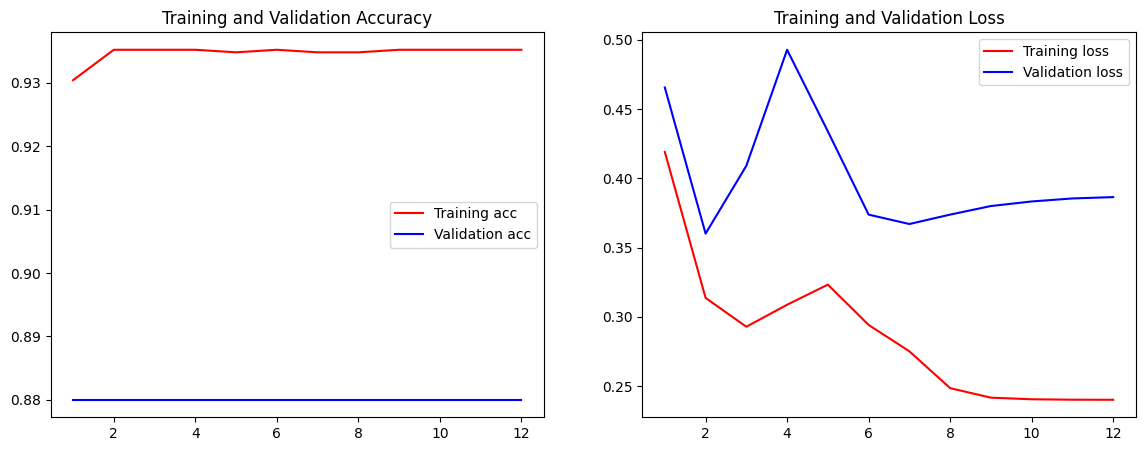

In [8]:
# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history.get('accuracy', [])  # 'accuracy' is not tracked for Siamese; replace with custom metrics if used
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    if acc and val_acc:
        plt.plot(epochs, acc, 'b', label='Training acc', color='red')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss', color='red')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot history
plot_history(history)

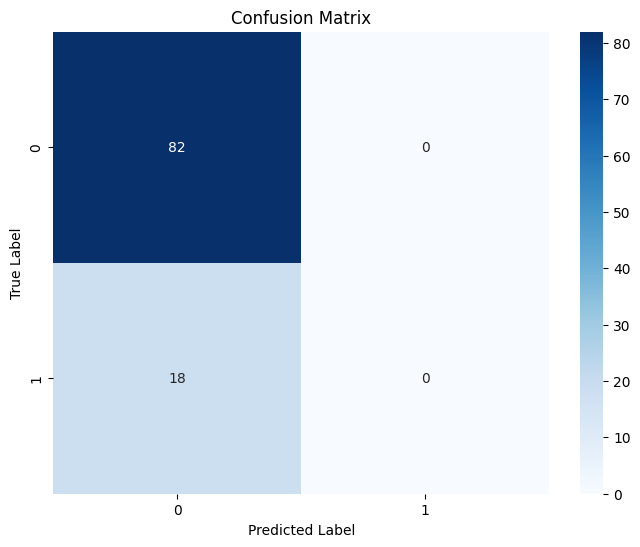

              precision    recall  f1-score   support

  Dissimilar       0.82      1.00      0.90        82
     Similar       0.00      0.00      0.00        18

    accuracy                           0.82       100
   macro avg       0.41      0.50      0.45       100
weighted avg       0.67      0.82      0.74       100



/home/bhavin/miniconda3/envs/Tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bhavin/miniconda3/envs/Tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bhavin/miniconda3/envs/Tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [8]:
# Function to generate confusion matrix and classification report
def evaluate_siamese_model(model, X_test_pairs, y_test_pairs, threshold=0.5):
    # Predict similarity scores for the test pairs
    y_pred_probs = model.predict([X_test_pairs[:, 0, :, :], X_test_pairs[:, 1, :, :]], verbose=0)
    
    # Convert similarity scores to binary predictions (0 or 1) based on the threshold
    y_pred = (y_pred_probs >= threshold).astype(int)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_pairs, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_test_pairs, y_pred, target_names=["Dissimilar", "Similar"]))

# Call the function to evaluate the model
evaluate_siamese_model(siamese_model, X_test_pairs, y_test_pairs)